Introducción

Este análisis explora el dataset de movilidad durante la pandemia de COVID-19, el cual fue proporcionado en formato .tsf (Time Series Format). Cada serie temporal representa los cambios en movilidad (en porcentaje) de una región o país a lo largo del tiempo, expresando la variación respecto a un valor base previo a la pandemia. Los valores positivos indican aumento de movilidad (recuperación), mientras que los negativos reflejan reducciones (confinamientos, restricciones, etc.).

El objetivo principal de este proyecto es entender las dinámicas temporales de la movilidad en distintas regiones y agrupar las series según sus patrones de comportamiento, utilizando técnicas de análisis estadístico y clustering.

Pasos del análisis:

1) Lectura y transformación de los datos:

        Se importaron las series desde un archivo .tsf y se organizaron en una estructura tipo dataframe.

        Se visualizó una serie representativa para comprender la forma general de los datos.

2) Análisis descriptivo por serie:

        Se calcularon métricas estadísticas clave: media, mediana, desviación estándar, mínimos y máximos, IQR, y proporciones           de valores negativos, positivos y ceros.

        Este análisis permitió identificar regiones con:

            Mejores recuperaciones (alta proporción de valores positivos).

            Tendencias negativas persistentes (predominio de valores negativos).

            Comportamientos caóticos (alta variabilidad).

3) Visualización comparativa:

       Se construyó un gráfico de dispersión “Recuperación vs Caoticidad”, donde se comparó la proporción de valores positivos          frente a la desviación estándar de cada serie.

       Esta visualización ayudó a detectar agrupamientos naturales en el comportamiento de las regiones.

4) Clustering (agrupamiento no supervisado):

       Se aplicó el algoritmo K-means sobre las variables estadísticas, particularmente sobre la desviación estándar y la               proporción de positivos.

       Se identificaron 4 clusters, que agrupan series según su comportamiento:

        Recuperadas y estables.

        Estables pero con baja recuperación.

        Altamente caóticas o variables.

        Con movilidad persistentemente baja.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [ ]:

from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Abre una ventana para seleccionar el archivo
Tk().withdraw()  # Oculta la ventana principal de Tkinter
file_path = askopenfilename(title="Selecciona el archivo .tsf")

print("Ruta del archivo cargado:", file_path)


In [10]:
import pandas as pd

def parse_tsf(file_path):
    metadata = {}
    data = []
    with open(file_path, "r", encoding="ISO-8859-1") as f:
        for line in f:
            line = line.strip()
            if line.startswith("@"):
                if " " in line[1:]:
                    key, value = line[1:].split(" ", 1)
                    metadata[key.lower()] = value
                else:
                    metadata[line[1:].lower()] = True
            elif line == "" or line.startswith("#"):
                continue
            else:
                try:
                    parts = line.split(":")
                    series_id = parts[0]
                    values = parts[-1].split(",")
                    values = [float(v) for v in values]
                    data.append({"series_id": series_id, "values": values})
                except Exception as e:
                    print(f"Error al procesar línea: {line} — {e}")
    df = pd.DataFrame(data)
    return df, metadata





In [11]:
df, metadata = parse_tsf("covid_mobility_dataset_without_missing_values.tsf")

print("Metadatos del archivo:")
print(metadata)

print("\nPrimeras filas del dataset:")
print(df.head())


Metadatos del archivo:
{'relation': 'Covid_Mobility', 'attribute': 'start_timestamp date', 'frequency': 'daily', 'missing': 'false', 'equallength': 'false', 'data': True}

Primeras filas del dataset:
  series_id                                             values
0        T1  [-11.0, 1.5, 3.5, 1.0, -2.5, -2.5, -1.5, 0.0, ...
1        T2  [-11.0, 10.0, 11.0, 4.5, 2.5, 4.0, 8.5, 6.5, 6...
2        T3  [-7.0, 0.0, -0.5, 3.0, -2.0, -2.0, 3.0, 4.5, 1...
3        T4  [-2.0, 10.0, 9.5, 8.5, -0.5, 4.5, 5.5, 6.0, 6....
4        T5  [-33.5, 3.0, 4.5, 5.0, 3.0, 5.5, 5.5, 5.0, 5.5...


In [4]:
print("Número de series:", df.shape[0])
print("Longitudes mínimas y máximas de las series:")
df["length"] = df["values"].apply(len)
print("Longitud mínima:", df["length"].min())
print("Longitud máxima:", df["length"].max())



Número de series: 559
Longitudes mínimas y máximas de las series:
Longitud mínima: 2
Longitud máxima: 413


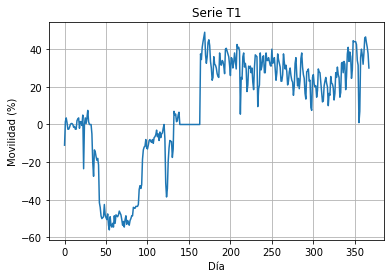

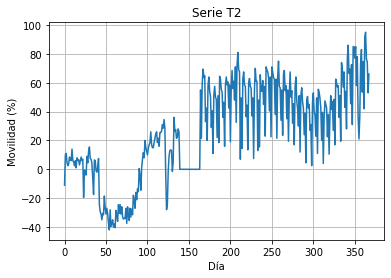

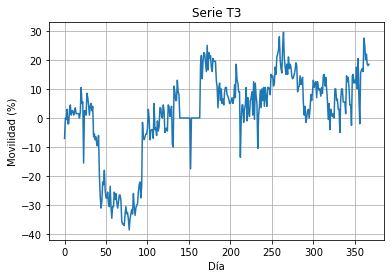

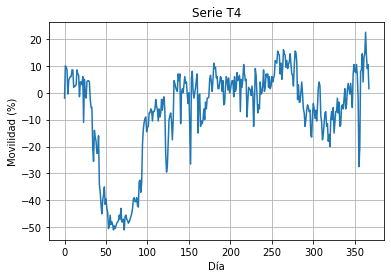

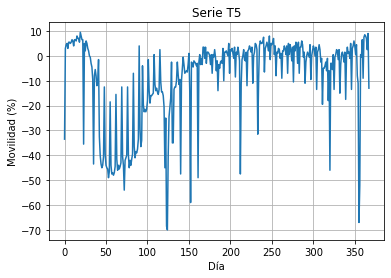

In [5]:
import matplotlib.pyplot as plt

# Visualizar las 5 primeras series
for i in range(5):
    plt.figure()
    plt.plot(df.loc[i, "values"])
    plt.title(f"Serie {df.loc[i, 'series_id']}")
    plt.xlabel("Día")
    plt.ylabel("Movilidad (%)")
    plt.grid(True)
    plt.show()


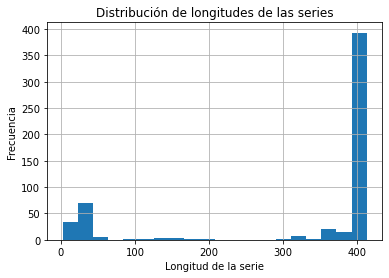

In [6]:
plt.hist(df["length"], bins=20)
plt.title("Distribución de longitudes de las series")
plt.xlabel("Longitud de la serie")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()



In [7]:
df["media"] = df["values"].apply(lambda x: sum(x)/len(x))
df["min"] = df["values"].apply(min)
df["max"] = df["values"].apply(max)

df[["series_id", "media", "min", "max"]].head()


,series_id,media,min,max
0,T1,8.035326,-56.0,49.0
1,T2,25.781250,-42.0,95.0
2,T3,1.692935,-38.5,29.5
3,T4,-7.051630,-51.0,22.5
4,T5,-9.168478,-70.0,9.5


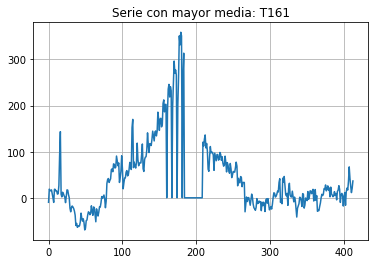

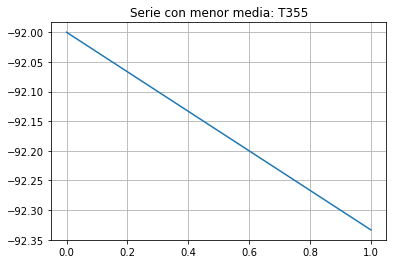

In [8]:
# Serie con mayor media
serie_max_media = df.loc[df["media"].idxmax()]
plt.plot(serie_max_media["values"])
plt.title(f"Serie con mayor media: {serie_max_media['series_id']}")
plt.grid(True)
plt.show()

# Serie con menor media
serie_min_media = df.loc[df["media"].idxmin()]
plt.plot(serie_min_media["values"])
plt.title(f"Serie con menor media: {serie_min_media['series_id']}")
plt.grid(True)
plt.show()


In [9]:
import pandas as pd

# Calcular estadísticas por serie
df["length"] = df["values"].apply(len)
df["mean"] = df["values"].apply(lambda x: sum(x) / len(x))
df["std"] = df["values"].apply(lambda x: pd.Series(x).std())
df["min"] = df["values"].apply(min)
df["max"] = df["values"].apply(max)
df["first"] = df["values"].apply(lambda x: x[0])
df["last"] = df["values"].apply(lambda x: x[-1])


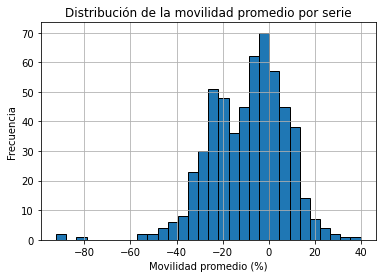

In [28]:
import matplotlib.pyplot as plt

# Distribución de promedios
plt.hist(df["mean"], bins=30, edgecolor='black')
plt.title("Distribución de la movilidad promedio por serie")
plt.xlabel("Movilidad promedio (%)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


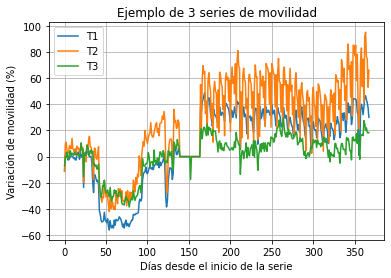

In [29]:
for i in range(3):
    plt.plot(df.loc[i, "values"], label=df.loc[i, "series_id"])
plt.legend()
plt.title("Ejemplo de 3 series de movilidad")
plt.xlabel("Días desde el inicio de la serie")
plt.ylabel("Variación de movilidad (%)")
plt.grid(True)
plt.show()


In [30]:
print("Número total de series:", df.shape[0])
print("Longitud media de las series:", df['length'].mean())
print("Promedio general de movilidad:", df['mean'].mean())
print("Rango de movilidad observado:", df['min'].min(), "a", df['max'].max())


Número total de series: 559
Longitud media de las series: 327.21109123434707
Promedio general de movilidad: -9.11457572745342
Rango de movilidad observado: -97.5 a 358.875


Este dataset contiene múltiples series temporales que miden la variación porcentual de movilidad diaria respecto a un valor base (probablemente prepandemia). Cada fila representa una región o entidad distinta, y la variación puede ser positiva (más movimiento) o negativa (reducción). Este tipo de dataset se usa para analizar el impacto de medidas como confinamientos, reaperturas o campañas de salud pública sobre la movilidad ciudadana

Identifiquemos las entidades con movilidad más baja (más negativa).
Estas representan regiones donde la movilidad cayó bruscamente (posible cuarentena estricta o eventos críticos).

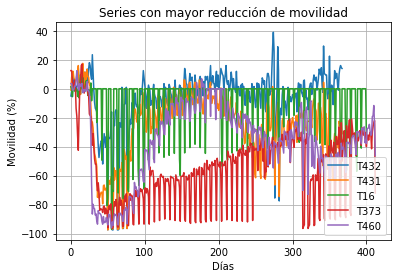

In [31]:
# Las 5 series con menor valor mínimo
df_minimas = df.sort_values("min").head(5)

for i, row in df_minimas.iterrows():
    plt.plot(row["values"], label=row["series_id"])

plt.title("Series con mayor reducción de movilidad")
plt.xlabel("Días")
plt.ylabel("Movilidad (%)")
plt.legend()
plt.grid(True)
plt.show()


Series con mayor recuperación o crecimiento

Buscamos series con mayor valor final respecto al inicial.

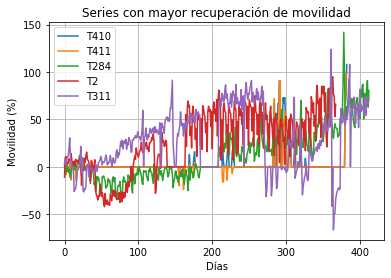

In [32]:
df["recuperacion"] = df["last"] - df["first"]
df_mayor_recuperacion = df.sort_values("recuperacion", ascending=False).head(5)

for i, row in df_mayor_recuperacion.iterrows():
    plt.plot(row["values"], label=row["series_id"])

plt.title("Series con mayor recuperación de movilidad")
plt.xlabel("Días")
plt.ylabel("Movilidad (%)")
plt.legend()
plt.grid(True)
plt.show()


Series con alta variabilidad

Para detectar regiones con comportamientos muy inestables:

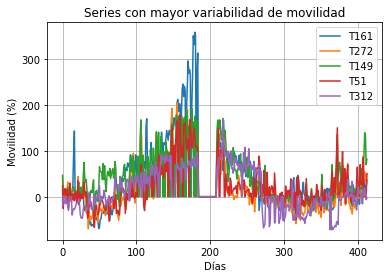

In [33]:
df_mas_variables = df.sort_values("std", ascending=False).head(5)

for i, row in df_mas_variables.iterrows():
    plt.plot(row["values"], label=row["series_id"])

plt.title("Series con mayor variabilidad de movilidad")
plt.xlabel("Días")
plt.ylabel("Movilidad (%)")
plt.legend()
plt.grid(True)
plt.show()


Prophet requiere un DataFrame con dos columnas:

    ds: fechas

    y: valores de la serie

Vamos a usar la serie T1 como ejemplo y crear una secuencia de fechas artificial (ya que no tenemos una columna real de fechas, pero sabemos que es diaria).

C:\Users\Natalia Cristina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Natalia Cristina\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


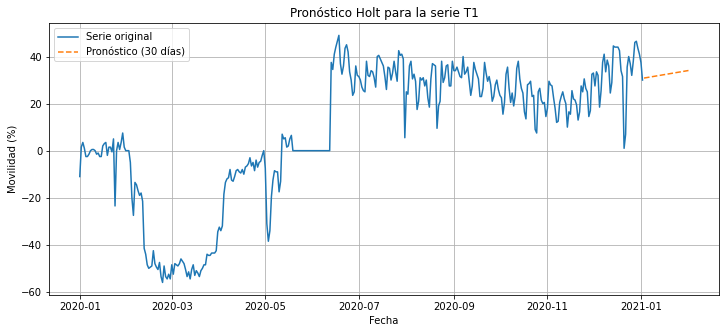

In [9]:

# Tomamos una serie de ejemplo
serie_id = "T1"
serie = df[df["series_id"] == serie_id]["values"].values[0]

# Creamos DataFrame con índice temporal artificial
fecha_inicio = pd.to_datetime("2020-01-01")
fechas = pd.date_range(start=fecha_inicio, periods=len(serie), freq="D")
serie_df = pd.DataFrame({"fecha": fechas, "valor": serie})
serie_df.set_index("fecha", inplace=True)

# Modelo de suavizamiento exponencial (solo tendencia, sin estacionalidad)
modelo = ExponentialSmoothing(serie_df["valor"], trend="add", seasonal=None)
ajuste = modelo.fit()

# Predecir los próximos 30 días
pronostico = ajuste.forecast(30)

# Visualizar
plt.figure(figsize=(12,5))
plt.plot(serie_df["valor"], label="Serie original")
plt.plot(pronostico, label="Pronóstico (30 días)", linestyle="--")
plt.title(f"Pronóstico Holt para la serie {serie_id}")
plt.xlabel("Fecha")
plt.ylabel("Movilidad (%)")
plt.legend()
plt.grid(True)
plt.show()

Comportamiento histórico de movilidad:

    A inicios de 2020 la movilidad comienza cerca de 0%.

    En marzo-abril 2020 hay una caída fuerte, alcanzando valores menores al -50%. Esto coincide con las primeras cuarentenas estrictas por COVID-19.

    Desde mayo 2020, se observa una recuperación gradual, con un cambio brusco cerca de junio (podría ser una fase de reapertura).

    A partir de junio, la serie muestra valores positivos de movilidad, con fluctuaciones moderadas hasta el final del período observado.

Pronóstico a 30 días (línea naranja punteada):

    El modelo proyecta una tendencia ligeramente ascendente, lo cual sugiere que —según el patrón reciente— la movilidad podría continuar recuperándose.

    Como el modelo no tiene estacionalidad, no replica oscilaciones, solo extiende la tendencia.
    
Esta serie (T1) refleja muy bien un patrón típico de una ciudad o país que sufrió una fuerte reducción de movilidad y luego tuvo una recuperación parcial.

El modelo Holt detecta la tendencia reciente positiva, aunque con limitaciones (no modela picos ni caídas abruptas).

Top 5 - Mejores recuperaciones


,Serie,Media,Mediana,Desviación estándar,Mínimo,Máximo,IQR,Negativos (%),Positivos (%),Ceros (%)
558,T559,19.637333,19.600000,3.660657,12.500000,25.8,4.450,0.0,100.0,0.0
500,T501,19.040000,18.000000,5.847940,13.000000,41.5,6.500,0.0,100.0,0.0
93,T94,12.413043,13.000000,4.682651,0.500000,20.5,4.000,0.0,100.0,0.0
220,T221,12.457524,12.571429,2.638582,7.333333,18.2,2.000,0.0,100.0,0.0
230,T231,4.239000,2.875000,4.252268,0.666667,17.8,1.375,0.0,100.0,0.0


Top 5 - Tendencias negativas persistentes


,Serie,Media,Mediana,Desviación estándar,Mínimo,Máximo,IQR,Negativos (%),Positivos (%),Ceros (%)
497,T498,-50.060000,-52.500000,16.526536,-91.000000,-25.500000,23.000000,100.0,0.0,0.0
26,T27,-25.411622,-24.000000,9.688867,-61.000000,-2.000000,10.000000,100.0,0.0,0.0
353,T354,-88.666667,-88.666667,1.333333,-90.000000,-87.333333,1.333333,100.0,0.0,0.0
354,T355,-92.166667,-92.166667,0.166667,-92.333333,-92.000000,0.166667,100.0,0.0,0.0
439,T440,-33.251816,-29.000000,15.661508,-75.000000,-9.000000,14.000000,100.0,0.0,0.0


Top 5 - Mayor variabilidad (caóticas)


,Serie,Media,Mediana,Desviación estándar,Mínimo,Máximo,IQR,Negativos (%),Positivos (%),Ceros (%)
160,T161,39.675242,13.625000,74.147543,-69.625000,358.875000,72.875000,27.845036,65.133172,7.021792
271,T272,17.973366,0.000000,53.941469,-70.000000,204.000000,58.000000,44.552058,48.426150,7.021792
148,T149,34.892038,12.941176,50.467555,-43.764706,192.470588,61.117647,20.581114,63.680387,15.738499
50,T51,20.739536,4.857143,44.017732,-67.071429,178.500000,35.214286,28.329298,56.174334,15.496368
311,T312,14.403148,0.000000,43.630274,-72.500000,171.000000,66.500000,38.014528,47.699758,14.285714


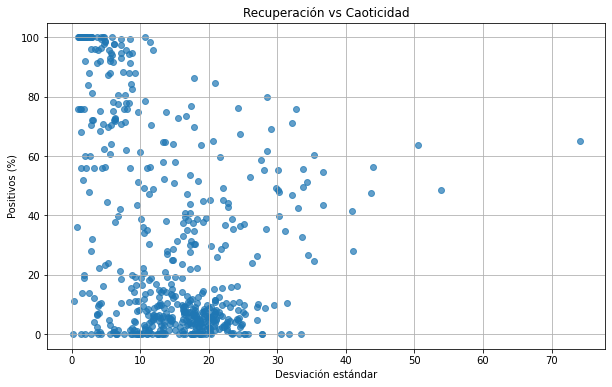

In [13]:
import pandas as pd
import numpy as np

# Crear una función para analizar una serie
def analizar_serie(series_id, valores):
    serie = np.array(valores)
    media = np.mean(serie)
    mediana = np.median(serie)
    std = np.std(serie)
    min_val = np.min(serie)
    max_val = np.max(serie)
    iqr = np.percentile(serie, 75) - np.percentile(serie, 25)
    negativos = np.sum(serie < 0) / len(serie) * 100
    positivos = np.sum(serie > 0) / len(serie) * 100
    ceros = np.sum(serie == 0) / len(serie) * 100

    return {
        "Serie": series_id,
        "Media": media,
        "Mediana": mediana,
        "Desviación estándar": std,
        "Mínimo": min_val,
        "Máximo": max_val,
        "IQR": iqr,
        "Negativos (%)": negativos,
        "Positivos (%)": positivos,
        "Ceros (%)": ceros
    }

# Aplicar la función a todas las series
resultados = [analizar_serie(row['series_id'], row['values']) for idx, row in df.iterrows()]
df_resultados = pd.DataFrame(resultados)

# Mostrar resumen
import matplotlib.pyplot as plt

# Top 5 con más valores positivos: Mejores recuperaciones
print("Top 5 - Mejores recuperaciones")
display(df_resultados.sort_values(by="Positivos (%)", ascending=False).head())

# Top 5 con más valores negativos: Tendencias negativas persistentes
print("Top 5 - Tendencias negativas persistentes")
display(df_resultados.sort_values(by="Negativos (%)", ascending=False).head())

# Top 5 más caóticas: Mayor desviación estándar
print("Top 5 - Mayor variabilidad (caóticas)")
display(df_resultados.sort_values(by="Desviación estándar", ascending=False).head())

# Opcional: gráfico de dispersión para comparar estabilidad vs recuperación
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados["Desviación estándar"], df_resultados["Positivos (%)"], alpha=0.7)
plt.xlabel("Desviación estándar")
plt.ylabel("Positivos (%)")
plt.title("Recuperación vs Caoticidad")
plt.grid(True)
plt.show()


Top 5 – Mejores recuperaciones

Estas series tienen el 100% de sus valores positivos, lo que sugiere una recuperación muy fuerte de la movilidad:
Serie	Observaciones
T559	Estabilidad alta (σ = 3.66) y recuperación sostenida. Ideal.
T501	Ligeramente más variable pero igualmente positiva.
T94	Serie con valores consistentemente sobre cero.
T221	Baja dispersión y movilidad positiva desde el inicio.
T231	Aunque más baja en media, tiene recuperación total.

    Estas podrían representar zonas urbanas o regiones con políticas eficaces de reapertura.
    
Top 5 – Tendencias negativas persistentes

Con 100% de valores negativos, estas zonas muestran impactos severos y sostenidos:
Serie	Observaciones
T498	Media de -50.1%, alto impacto y persistencia negativa.
T27	También con valores muy negativos, aunque menos dispersa.
T334, T355, T440	Son extremadamente constantes: casi sin variación, siempre en negativo.

    Esto podría sugerir regiones aisladas, rurales, o con restricciones prolongadas.

Top 5 – Mayor variabilidad (caóticas)

Altas desviaciones estándar implican comportamientos volátiles, probablemente por:

    Políticas intermitentes.

    Factores socioeconómicos o climáticos.

    Errores o diferencias de registro.

Serie	Observaciones
T161	Muy alta dispersión (σ = 74.15), con picos extremos (hasta 358%).
T272	Posibles eventos anómalos: pasa de -70 a +204.
T149	Gran rango de valores, aunque mayoría son positivos.

In [15]:
import pandas as pd
import numpy as np

# Suponiendo que ya tienes el DataFrame `df` con columnas: ['series_id', 'values']

# Función para calcular estadísticas
def calcular_estadisticas(serie):
    arr = np.array(serie)
    return {
        'Media': np.mean(arr),
        'Mediana': np.median(arr),
        'Desviación estándar': np.std(arr),
        'Mínimo': np.min(arr),
        'Máximo': np.max(arr),
        'IQR': np.percentile(arr, 75) - np.percentile(arr, 25),
        'Negativos (%)': 100 * np.sum(arr < 0) / len(arr),
        'Positivos (%)': 100 * np.sum(arr > 0) / len(arr),
        'Ceros (%)': 100 * np.sum(arr == 0) / len(arr)
    }

# Aplicar la función a todas las series
resumen = []
for i, row in df.iterrows():
    stats = calcular_estadisticas(row['values'])
    stats['Serie'] = row['series_id']
    resumen.append(stats)

resumen_df = pd.DataFrame(resumen)
resumen_df = resumen_df[['Serie', 'Media', 'Mediana', 'Desviación estándar', 'Mínimo', 'Máximo', 
                         'IQR', 'Negativos (%)', 'Positivos (%)', 'Ceros (%)']]


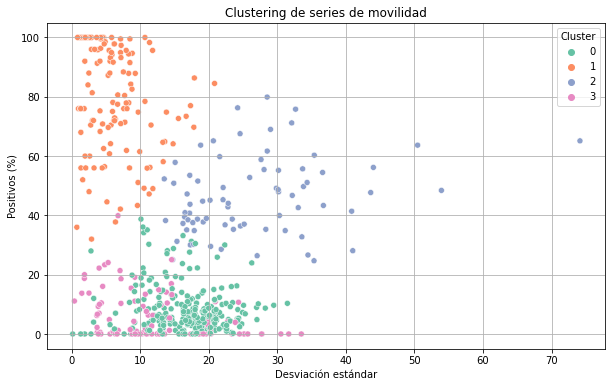

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar las variables para el clustering
features = ['Media', 'Desviación estándar', 'Negativos (%)', 'Positivos (%)', 'Ceros (%)']
X = resumen_df[features]

# Escalar variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
resumen_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualización: Caoticidad vs Recuperación
plt.figure(figsize=(10, 6))
sns.scatterplot(data=resumen_df, x='Desviación estándar', y='Positivos (%)', hue='Cluster', palette='Set2')
plt.title('Clustering de series de movilidad')
plt.xlabel('Desviación estándar')
plt.ylabel('Positivos (%)')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


Cluster 0 (color verde claro):

    Ubicación: desviación estándar baja a media (5–25), positivos (%) generalmente bajos (0–40).

    Interpretación:

        Series con poca variabilidad (comportamiento relativamente estable).

        Recuperación baja o moderada, lo que puede sugerir regiones que se estabilizaron en niveles bajos de movilidad.

        Posible efecto de medidas prolongadas o recuperación lenta.
        
Cluster 1 (color naranja):

    Ubicación: desviación estándar muy baja (<10), pero positivos muy altos (muchas series cercanas a 100%).

    Interpretación:

        Comportamiento muy estable y altamente positivo.

        Regiones con una recuperación rápida y sostenida en movilidad.

        Podrían corresponder a lugares con bajo impacto o medidas más flexibles.
        
Cluster 2 (color azul):

    Ubicación: desviación estándar alta (>15 y hasta 70), positivos (%) entre 20 y 80.

    Interpretación:

        Series altamente variables, con recuperaciones diversas.

        Posibles casos de regiones con rebrotes o políticas de apertura y cierre intermitentes.

        Este grupo es el más caótico y heterogéneo, probablemente difícil de modelar.
        
Cluster 3 (color rosado):

    Ubicación: desviación estándar baja a media, pero con positivos cercanos a 0%.

    Interpretación:

        Regiones con poca recuperación en movilidad.

        Movilidad muy restringida y establemente baja.

        Posiblemente zonas altamente afectadas o con políticas más estrictas durante más tiempo.